In [1]:
#import xgboost as xgb
import pandas as pd
import numpy as np
import math as ma
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import linregress

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

all_df_list = [df_train,df_test]

#for later on
#scores = -1 * cross_val_score(my_pipeline, X, y,
#                              cv=5,
#                              scoring='neg_mean_absolute_error')

def makeDict(df,label):
    strcat_dict = {}
    for i,row in df.iterrows():
        strcat_dict[row[label]] = i 
    return strcat_dict

def makeOrdinal(df,label,showDict):
    filtered = df.sort_values([label], ascending = [True])
    df_filtered = filtered.groupby(label).first().reset_index()
    strcat_dict = {}
    
    for i,row in df_filtered.iterrows():
        strcat_dict[row[label]] = i 
    
    if showDict:
        print(strcat_dict)
    
    for j,row in df.iterrows():
        df.at[j,label] = strcat_dict.get(row[label])
    
    return df

df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2]:
categorical_cols = ["MSZoning","Street","Alley","LotShape","LandContour","LotConfig",\
                    "LandSlope","Neighborhood","Condition1","Condition2","BldgType",\
                    "HouseStyle","RoofStyle","RoofMatl","Exterior1st","Exterior2nd",\
                    "MasVnrType","ExterQual","ExterCond","Foundation","BsmtQual",\
                    "BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2",\
                    "Heating","HeatingQC","CentralAir","Electrical","KitchenQual",\
                    "Functional","FireplaceQu","GarageType","GarageFinish",\
                    "GarageQual","GarageCond","PavedDrive","Fence",\
                    "MiscFeature","SaleType","SaleCondition"]

for column in categorical_cols:
    for df_single in all_df_list:
        makeOrdinal(df_single,column,True)

#drop columns that are too sparse to be of any statistical significance
#print("Before", df_train.shape, df_test.shape, all_df_list[0].shape, all_df_list[1].shape)

df_train = df_train.drop(['Utilities','PoolArea','PoolQC'], axis=1)
df_test = df_test.drop(['Utilities','PoolArea','PoolQC'], axis=1)
all_df_list = [df_train,df_test]

#print("After", df_train.shape, df_test.shape, all_df_list[0].shape, all_df_list[1].shape)
df_train.head(150)

{'C (all)': 0, 'FV': 1, 'RH': 2, 'RL': 3, 'RM': 4}
{'C (all)': 0, 'FV': 1, 'RH': 2, 'RL': 3, 'RM': 4}
{'Grvl': 0, 'Pave': 1}
{'Grvl': 0, 'Pave': 1}
{'Grvl': 0, 'Pave': 1}
{'Grvl': 0, 'Pave': 1}
{'IR1': 0, 'IR2': 1, 'IR3': 2, 'Reg': 3}
{'IR1': 0, 'IR2': 1, 'IR3': 2, 'Reg': 3}
{'Bnk': 0, 'HLS': 1, 'Low': 2, 'Lvl': 3}
{'Bnk': 0, 'HLS': 1, 'Low': 2, 'Lvl': 3}
{'Corner': 0, 'CulDSac': 1, 'FR2': 2, 'FR3': 3, 'Inside': 4}
{'Corner': 0, 'CulDSac': 1, 'FR2': 2, 'FR3': 3, 'Inside': 4}
{'Gtl': 0, 'Mod': 1, 'Sev': 2}
{'Gtl': 0, 'Mod': 1, 'Sev': 2}
{'Blmngtn': 0, 'Blueste': 1, 'BrDale': 2, 'BrkSide': 3, 'ClearCr': 4, 'CollgCr': 5, 'Crawfor': 6, 'Edwards': 7, 'Gilbert': 8, 'IDOTRR': 9, 'MeadowV': 10, 'Mitchel': 11, 'NAmes': 12, 'NPkVill': 13, 'NWAmes': 14, 'NoRidge': 15, 'NridgHt': 16, 'OldTown': 17, 'SWISU': 18, 'Sawyer': 19, 'SawyerW': 20, 'Somerst': 21, 'StoneBr': 22, 'Timber': 23, 'Veenker': 24}
{'Blmngtn': 0, 'Blueste': 1, 'BrDale': 2, 'BrkSide': 3, 'ClearCr': 4, 'CollgCr': 5, 'Crawfor': 6, 'Ed

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,...,3SsnPorch,ScreenPorch,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,None,3,3,4,...,0,0,None,None,0,2,2008,8,4,208500
1,2,20,3,80.0,9600,1,None,3,3,2,...,0,0,None,None,0,5,2007,8,4,181500
2,3,60,3,68.0,11250,1,None,0,3,4,...,0,0,None,None,0,9,2008,8,4,223500
3,4,70,3,60.0,9550,1,None,0,3,0,...,0,0,None,None,0,2,2006,8,0,140000
4,5,60,3,84.0,14260,1,None,0,3,2,...,0,0,None,None,0,12,2008,8,4,250000
5,6,50,3,85.0,14115,1,None,0,3,4,...,320,0,2,2,700,10,2009,8,4,143000
6,7,20,3,75.0,10084,1,None,3,3,4,...,0,0,None,None,0,8,2007,8,4,307000
7,8,60,3,NaN,10382,1,None,0,3,0,...,0,0,None,2,350,11,2009,8,4,200000
8,9,50,4,51.0,6120,1,None,3,3,4,...,0,0,None,None,0,4,2008,8,0,129900
9,10,190,3,50.0,7420,1,None,3,3,0,...,0,0,None,None,0,1,2008,8,4,118000


In [3]:
#Analysis only
#only select the int or float columns
int_cols = [cname for cname in df_train.columns if df_train[cname].dtype in ['int64']]
float_cols = [cname for cname in df_train.columns if df_train[cname].dtype in ['float64']]

sale_values = df_train['SalePrice']
primary_correlations = []
for val in int_cols:
    int_regression = linregress(df_train[val],sale_values)
    primary_correlations.append((val,[int_regression.rvalue,\
                                      int_regression.pvalue]))
    #print(linregress(df_train[val],sale_values))

df_float_cor = df_train.copy()

for i,row in df_float_cor[float_cols].iterrows():
    if ma.isnan(row['LotFrontage']):
        df_float_cor.at[i,'LotFrontage'] = 0 #nan means no frontage, so 0 is sensible
    if ma.isnan(row['MasVnrArea']):
        df_float_cor.at[i,'MasVnrArea'] = 0 #nan means no area, so 0 is sensible
    if ma.isnan(row['GarageYrBlt']):
        df_float_cor.at[i,'GarageYrBlt'] = df_train['GarageYrBlt'].mean() #nan means unknown, so use the mean

for val in float_cols:
    float_regression = linregress(df_float_cor[val],sale_values)
    primary_correlations.append((val,[float_regression.rvalue,\
                                      float_regression.pvalue]))
        
print("number of numeric columns:",len(primary_correlations))
correldf = pd.DataFrame(primary_correlations, columns=["column name","r value,p value"])
correldf.sort_values(by='r value,p value',ascending=True)

#5 to 10 are possibly not significantly correlated, but they are not correlated anyway
#all these others are infinitesmally small numbers, so the correlations are signifincant

number of numeric columns: 37


,column name,"r value,p value"
20,KitchenAbvGr,"[-0.13590737084214113, 1.8604260320753142e-07]"
27,EnclosedPorch,"[-0.1285779579259565, 8.255770475113626e-07]"
1,MSSubClass,"[-0.08428413512659526, 0.0012664716847494513]"
4,OverallCond,"[-0.077855894048678, 0.002912351267915496]"
32,YrSold,"[-0.028922585168730336, 0.2694131932808423]"
13,LowQualFinSF,"[-0.02560613000067959, 0.3282073098405298]"
0,Id,"[-0.021916719443431106, 0.4026937997557728]"
30,MiscVal,"[-0.021189579640303248, 0.4184863494080361]"
16,BsmtHalfBath,"[-0.01684415429735902, 0.5201536357277561]"
8,BsmtFinSF2,"[-0.011378121450215137, 0.6639986508340909]"


In [4]:
# Imputation
df_pca_train = df_train.copy()
df_pca_test = df_test.copy()

y = df_pca_train['SalePrice']
sale_predictors = df_pca_train.drop(['SalePrice'], axis=1)
X = sale_predictors.select_dtypes(exclude=['object'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=0)

my_imputer = SimpleImputer(strategy='mean')
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))

# Imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

#data has been split into variables, which is why there is now only 1168 rows
print(np.shape(imputed_X_train))

(1168, 36)


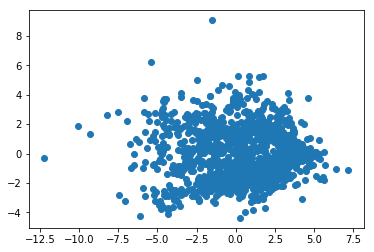

In [5]:
#standardising all the data now it's been imputed (makes mean 0 and standard dev 1)
imputed_X_train = StandardScaler().fit_transform(imputed_X_train)

meanVals = np.mean(imputed_X_train, axis=0)
covarianceMatrix = (imputed_X_train - meanVals).T.dot((imputed_X_train - meanVals)) / (imputed_X_train.shape[0] - 1)

eValues, eVec = np.linalg.eig(covarianceMatrix)

eigenPairs = [(np.abs(eValues[i]), eVec[:, i]) for i in range(len(eValues))]
eigenPairs.sort()
eigenPairs.reverse()

top2Matrix = np.hstack((eigenPairs[0][1].reshape(36,1), eigenPairs[1][1].reshape(36,1)))
principalComp = imputed_X_train.dot(top2Matrix)

#this plot is meaningless really. the benefit of the PCA performed
#is to catch most of the variance in the dataset in these two columns we are left with
plt.scatter(principalComp[:,:1],principalComp[:,1:2])
plt.show()

In [6]:
rf = RandomForestRegressor(random_state=1,n_estimators=10)
rf.fit(principalComp,y_train)

##### now make the test PCA
imputed_X_valid = StandardScaler().fit_transform(imputed_X_valid)
meanVals = np.mean(imputed_X_valid, axis=0)
covarianceMatrix = (imputed_X_valid - meanVals).T.dot((imputed_X_valid - meanVals)) / (imputed_X_valid.shape[0] - 1)

eValues, eVec = np.linalg.eig(covarianceMatrix)

eigenPairs = [(np.abs(eValues[i]), eVec[:, i]) for i in range(len(eValues))]
eigenPairs.sort()
eigenPairs.reverse()

top2Matrix = np.hstack((eigenPairs[0][1].reshape(36,1), eigenPairs[1][1].reshape(36,1)))
principalComp_valid = imputed_X_valid.dot(top2Matrix)

price_predictions = rf.predict(principalComp_valid)

#error seems very low...something could be off though
print(mean_absolute_error(y_valid,price_predictions))

24219.416438356166


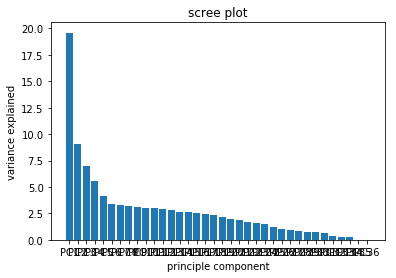

In [7]:
pca = PCA()
pca.fit(imputed_X_train)
pca_fin = pca.transform(imputed_X_train)
per_var = np.round(pca.explained_variance_ratio_ * 100,decimals=1)
labelsp = ['PC' + str(x) for x in range(1,len(per_var)+1)]
plt.bar(x=range(1,len(per_var)+1),height=per_var,tick_label=labelsp)
plt.xlabel("principle component")
plt.ylabel("variance explained")
plt.title("scree plot")
plt.show()

#this plot shows that only approximately 36% of the variation is accounted for in this PCA
#the usual threshold might be 95% if we were being strict, but a minimum of 60% for it to be useable

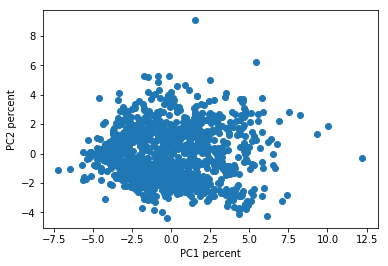

In [8]:
#not very useful again since it's just one big blob of data
pca_df = pd.DataFrame(pca_fin,columns=labelsp)
plt.scatter(pca_df.PC1,pca_df.PC2)
plt.xlabel("PC1 percent")
plt.ylabel("PC2 percent")
plt.show()